In [1]:
import os
import random
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.models as models
import timm
from PIL import  ImageEnhance

تعداد نمونه‌های آموزش: 386
تعداد نمونه‌های اعتبارسنجی: 109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].


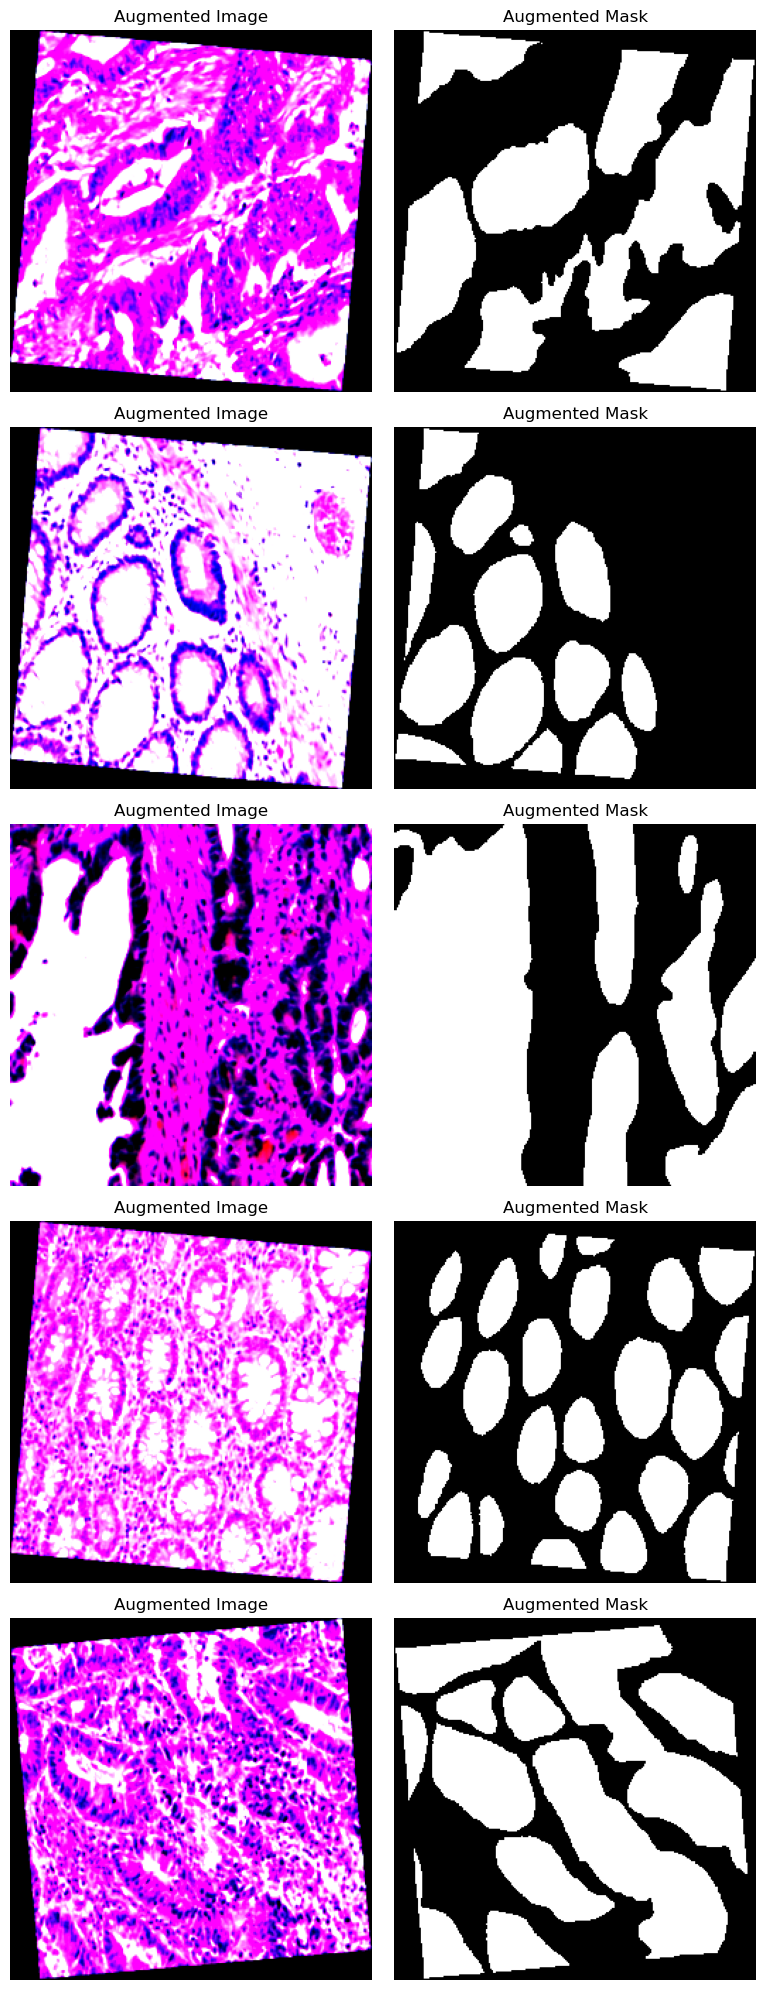

In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, images_folder, masks_folder, transform=None, augmentation=True):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.transform = transform
        self.augmentation = augmentation
        self.image_names = os.listdir(images_folder)
    def __len__(self):
        return len(self.image_names)
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.images_folder, image_name)
        mask_path = os.path.join(self.masks_folder, image_name)
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        if self.augmentation:
            angle = random.uniform(-0,0)
            image = T.functional.rotate(image, angle)
            mask = T.functional.rotate(mask, angle)
            image = image.filter(ImageFilter.GaussianBlur(radius=1.2))
        if self.transform:
            image = self.transform(image)
            mask = T.Resize((256, 256))(mask)
            mask = T.ToTensor()(mask).squeeze(0)
        return image, mask.long()
transform = T.Compose([T.Resize((256, 256)),T.ToTensor(),T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
images_folder = r'G:\paper-payanname\glas\1'
masks_folder = r'G:\paper-payanname\glas\2'

dataset = SegmentationDataset(images_folder, masks_folder, transform=transform, augmentation=True)
image_names_train, image_names_val = train_test_split(dataset.image_names, test_size=0.22, random_state=42)
train_dataset = SegmentationDataset(images_folder, masks_folder, transform=transform, augmentation=True)
train_dataset.image_names = image_names_train  
val_dataset = SegmentationDataset(images_folder, masks_folder, transform=transform, augmentation=False)
val_dataset.image_names = image_names_val  
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
print(f"تعداد نمونه‌های آموزش: {len(train_dataset)}")
print(f"تعداد نمونه‌های اعتبارسنجی: {len(val_dataset)}")
def show_augmented_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))
    for i in range(num_samples):
        image, mask = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()  
        mask_np = mask.numpy()
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title("Augmented Image")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title("Augmented Mask")
        axes[i, 1].axis("off")
    plt.tight_layout()
    plt.show()
show_augmented_samples(train_dataset)

5

In [3]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
padding=padding, dilation=dilation, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.activation(x)

class RFB_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(RFB_Block, self).__init__()

        self.branch0 = BasicConv2d(in_channels, out_channels, kernel_size=1)
        self.branch1 = self._make_branch(in_channels, out_channels, dilation=3)
        self.branch2 = self._make_branch(in_channels, out_channels, dilation=5)
        self.branch3 = self._make_branch(in_channels, out_channels, dilation=7)

        self.conv_cat = BasicConv2d(4 * out_channels, out_channels, kernel_size=3, padding=1)
        self.conv_res = BasicConv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def _make_branch(self, in_channels, out_channels, dilation):
        return nn.Sequential(BasicConv2d(in_channels, out_channels, kernel_size=1),BasicConv2d(out_channels, out_channels, kernel_size=3, padding=1, dilation=1, groups=2),  
            BasicConv2d(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, groups=2))

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)


        out = torch.cat([x0, x1, x2, x3], 1)
        out = self.conv_cat(out)

        res = self.conv_res(x)
        gate = torch.sigmoid(out)  
        out = gate * out + (1 - gate) * res
        return out



class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()

        self.conv1_depthwise = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
        self.conv1_pointwise = nn.Conv2d(64, 64, kernel_size=1)

        self.conv2_depthwise = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
        self.conv2_pointwise = nn.Conv2d(64, 32, kernel_size=1)

        self.conv3_depthwise = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.conv3_pointwise = nn.Conv2d(32, 16, kernel_size=1)

        self.conv4_depthwise = nn.Conv2d(16, 16, kernel_size=3, padding=1, groups=16)
        self.conv4_pointwise = nn.Conv2d(16, 8, kernel_size=1)

        self.dropout = nn.Dropout(p=0.25)

        self.adjust_conv2 = nn.Conv2d(64, 32, kernel_size=1)
        self.adjust_conv3 = nn.Conv2d(32, 16, kernel_size=1)

        self.final_conv = nn.Conv2d(24, 1, kernel_size=3,padding=1)

    def forward(self, x):
        x1 = self.conv1_depthwise(x)
        x1 = self.conv1_pointwise(x1)
        x1 = nn.ReLU()(x1)
        x1 = self.dropout(x1)

        x2 = self.conv2_depthwise(x1)
        x2 = self.conv2_pointwise(x2)
        x2 = nn.ReLU()(x2)
        x2 = self.dropout(x2)
        x2 = x2 + self.adjust_conv2(x1)

        x3 = self.conv3_depthwise(x2)
        x3 = self.conv3_pointwise(x3)
        x3 = nn.ReLU()(x3)
        x3 = self.dropout(x3)
        x3 = x3 + self.adjust_conv3(x2)

        x4 = self.conv4_depthwise(x3)
        x4 = self.conv4_pointwise(x4)
        x4 = nn.ReLU()(x4)
        x4 = torch.cat((x4, x3), dim=1)

        x = self.final_conv(x4)
        return x


#New---CBAM----
class GeM(nn.Module):
    def __init__(self, p=2, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return F.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(1.0 / self.p)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.gem_pool = GeM()
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        gem_out = self.gem_pool(x)
        out = self.fc2(self.relu1(self.fc1(gem_out)))
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(2, 1, kernel_size=5, padding=2, bias=False)
        self.conv3 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)

        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)

        x = (x1 + x2 + x3) / 3
        return self.sigmoid(x)


class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=8, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x
    


#########################################################################
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_prob=0.0):
        super(DepthwiseSeparableConv, self).__init__()
        
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.dropout = nn.Dropout2d(p=dropout_prob) if dropout_prob > 0 else nn.Identity()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.dropout(x)
        return x

class FinalSegmentationModel(nn.Module):
    def __init__(self, num_classes=1): 
        super(FinalSegmentationModel, self).__init__()

        self.swin_transformer = timm.create_model('swinv2_tiny_window8_256', pretrained=False, features_only=True
                                                   ,out_indices=(0, 1, 2, 3),embed_dim=48, window_size=8 )
        
        self.swin56 = DepthwiseSeparableConv(48, 64, kernel_size=3, padding=1, dropout_prob=0.25)
        self.swin28 = DepthwiseSeparableConv(96, 128, kernel_size=3, padding=1, dropout_prob=0.25)
        self.swin14 = DepthwiseSeparableConv(192, 256, kernel_size=3, padding=1, dropout_prob=0.45)
        self.swin7 = DepthwiseSeparableConv(384, 384, kernel_size=3, padding=1, dropout_prob=0.45)


        self.upsample4 =nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.rfb4 = RFB_Block(640, 192)
        self.cbam4 = CBAM(192)  
        self.conv_decoder4 = nn.Sequential(nn.Conv2d(192, 192, kernel_size=3,padding=1), nn.BatchNorm2d(192), nn.GELU(),nn.Dropout(p=0.25))


        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.rfb3 = RFB_Block(320, 128)
        self.cbam3 = CBAM(128)  
        self.conv_decoder3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3,padding=1), nn.BatchNorm2d(128), nn.GELU(),nn.Dropout(p=0.25))


        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.rfb2 = RFB_Block(192, 96)
        self.cbam2 = CBAM(96)  
        self.conv_decoder2 = nn.Sequential(nn.Conv2d(96, 96, kernel_size=3,padding=1), nn.BatchNorm2d(96), nn.GELU(),nn.Dropout (p=0.25))


        self.upsample1= nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_decoder1 = nn.Sequential(nn.Conv2d(96, 96, kernel_size=3,padding=1), nn.BatchNorm2d(96), nn.GELU(),nn.Dropout(p=0.1))


        self.upsample0= nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_decoder0 = nn.Sequential(nn.Conv2d(96, 64, kernel_size=3,padding=1), nn.BatchNorm2d(64), nn.GELU(),nn.Dropout(p=0.1))

        self.final_conv= MyNetwork()

    def forward(self, x):
        features = self.swin_transformer(x)

        features56 = features[-4].permute(0, 3, 1, 2)
        features56 = self.swin56(features56)

        features28 = features[-3].permute(0, 3, 1, 2)
        features28 = self.swin28(features28)

        features14 = features[-2].permute(0, 3, 1, 2)
        features14 = self.swin14(features14)

        convnext_features7 = features[-1].permute(0, 3, 1, 2)
        convnext_features7 = self.swin7(convnext_features7)

        d4 = self.upsample4(convnext_features7)
        d4 = torch.cat([d4, features14], dim=1)
        d4 = self.rfb4(d4)
        d4 = self.cbam4(d4)  
        d4 = self.conv_decoder4(d4)

        d3 = self.upsample3(d4)
        d3 = torch.cat([d3, features28], dim=1)
        d3 = self.rfb3(d3)
        d3 = self.cbam3(d3)  
        d3 = self.conv_decoder3(d3)

        d2 = self.upsample2(d3)
        d2 = torch.cat([d2, features56], dim=1)
        d2 = self.rfb2(d2)
        d2 = self.cbam2(d2) 
        d2 = self.conv_decoder2(d2)

        d1 = self.upsample1(d2)
        d1 = self.conv_decoder1(d1)

        d0 = self.upsample0(d1)
        d0 = self.conv_decoder0(d0)

        return self.final_conv(d0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = FinalSegmentationModel(num_classes=1).to(device)
print("Model architecture:")
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Frozen parameters: {frozen_params}")
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

Using device: cuda
Model architecture:
FinalSegmentationModel(
  (swin_transformer): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 48, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerV2Stage(
      (downsample): Identity()
      (blocks): ModuleList(
        (0): SwinTransformerV2Block(
          (attn): WindowAttention(
            (cpb_mlp): Sequential(
              (0): Linear(in_features=2, out_features=512, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=512, out_features=3, bias=False)
            )
            (qkv): Linear(in_features=48, out_features=144, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=48, out_features=48, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (norm1): LayerNorm(

In [4]:
from ptflops import get_model_complexity_info

model = FinalSegmentationModel()  
input_size = (3, 256, 256)  
flops, params = get_model_complexity_info(model, input_size, as_strings=True, print_per_layer_stat=False)
print(f"Total FLOPs: {flops.replace('GMac', 'GFLOPs')}")

Total FLOPs: 12.35 GFLOPs


In [4]:
from sklearn.metrics import recall_score, jaccard_score, confusion_matrix

# BCE Loss
def bce_loss(pred, target):
    return F.binary_cross_entropy_with_logits(pred, target, reduction='mean')

# IoU Loss
def iou_loss(pred, target):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    union = (pred + target - pred * target).sum(dim=(2, 3))
    iou = (intersection + 1e-7) / (union + 1e-7)
    return 1 - iou.mean()

# ترکیب BCE + IoU Loss
def total_loss(pred, target, bce_weight=0.7, iou_weight=0.3):
    bce = bce_loss(pred, target)
    iou = iou_loss(pred, target)
    
    return (bce_weight * bce + iou_weight * iou) / (bce_weight + iou_weight)

# محاسبه Dice Coefficient
def dice_coefficient(preds, masks):
    intersection = (preds * masks).sum()
    dice = (2. * intersection) / (preds.sum() + masks.sum() + 1e-7)
    return dice


# محاسبه تمامی معیارها
def compute_metrics(preds, masks):
    preds = preds.flatten()
    masks = masks.flatten()
    
    # باینری کردن داده‌ها با آستانه
    preds = (preds > 0.5).astype(np.uint8)
    masks = (masks > 0.5).astype(np.uint8)

    iou = jaccard_score(masks, preds, average='binary', zero_division=1)
    dice = dice_coefficient(preds, masks)
    return   iou, dice

# آموزش مدل
def train_model(model, train_loader, val_loader, total_loss, optimizer, device, num_epochs=50, threshold=0.42):
    train_loss_history, val_loss_history = [], []
    train_metrics_history, val_metrics_history = [], []

    for epoch in range(num_epochs):
        # ===== آموزش =====
        model.train()
        train_loss, all_preds, all_masks = 0.0, [], []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device).float()
            optimizer.zero_grad()
            
            # پیش‌بینی و محاسبه زیان
            outputs = model(images)
            loss = total_loss(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            # ذخیره پیش‌بینی‌ها و ماسک‌ها
            preds = (torch.sigmoid(outputs) > threshold).float()
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

        # محاسبه معیارها برای داده‌های آموزش
        train_loss /= len(train_loader.dataset)
        all_preds, all_masks = np.concatenate(all_preds), np.concatenate(all_masks)
        train_metrics = compute_metrics(all_preds, all_masks)
        train_loss_history.append(train_loss)
        train_metrics_history.append(train_metrics)

        # ===== اعتبارسنجی =====
        model.eval()
        val_loss, val_preds, val_masks = 0.0, [], []

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).float()
                outputs = model(images)
                loss = total_loss(outputs, masks.unsqueeze(1))
                val_loss += loss.item() * images.size(0)

                preds = (torch.sigmoid(outputs) > threshold).float()
                val_preds.append(preds.cpu().numpy())
                val_masks.append(masks.cpu().numpy())

        # محاسبه معیارها برای داده‌های اعتبارسنجی
        val_loss /= len(val_loader.dataset)
        val_preds, val_masks = np.concatenate(val_preds), np.concatenate(val_masks)
        val_metrics = compute_metrics(val_preds, val_masks)
        val_loss_history.append(val_loss)
        val_metrics_history.append(val_metrics)

        # ===== گزارش نتایج =====
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
        print(f"  Training Metrics: IOU={train_metrics[0]:.4f}, Dice={train_metrics[1]:.4f}, ")
        print(f"  Validation Metrics:  IOU={val_metrics[0]:.4f}, Dice={val_metrics[1]:.4f}, ")
        print("")
    return train_loss_history, val_loss_history, train_metrics_history, val_metrics_history

train_loss, val_loss, train_metrics, val_metrics = train_model(model, train_loader, val_loader, total_loss, optimizer, device)

Epoch 1/50
  Training Loss: 0.6469 | Validation Loss: 0.5754
  Training Metrics: IOU=0.4790, Dice=0.6477, 
  Validation Metrics:  IOU=0.5433, Dice=0.7041, 

Epoch 2/50
  Training Loss: 0.4794 | Validation Loss: 0.4137
  Training Metrics: IOU=0.6128, Dice=0.7599, 
  Validation Metrics:  IOU=0.6670, Dice=0.8003, 

Epoch 3/50
  Training Loss: 0.3734 | Validation Loss: 0.3730
  Training Metrics: IOU=0.6938, Dice=0.8192, 
  Validation Metrics:  IOU=0.7048, Dice=0.8269, 

Epoch 4/50
  Training Loss: 0.3264 | Validation Loss: 0.3730
  Training Metrics: IOU=0.7282, Dice=0.8427, 
  Validation Metrics:  IOU=0.6998, Dice=0.8234, 

Epoch 5/50
  Training Loss: 0.3002 | Validation Loss: 0.2914
  Training Metrics: IOU=0.7518, Dice=0.8583, 
  Validation Metrics:  IOU=0.7694, Dice=0.8697, 

Epoch 6/50
  Training Loss: 0.2532 | Validation Loss: 0.2745
  Training Metrics: IOU=0.7880, Dice=0.8814, 
  Validation Metrics:  IOU=0.7812, Dice=0.8771, 

Epoch 7/50
  Training Loss: 0.2410 | Validation Loss: 0.29

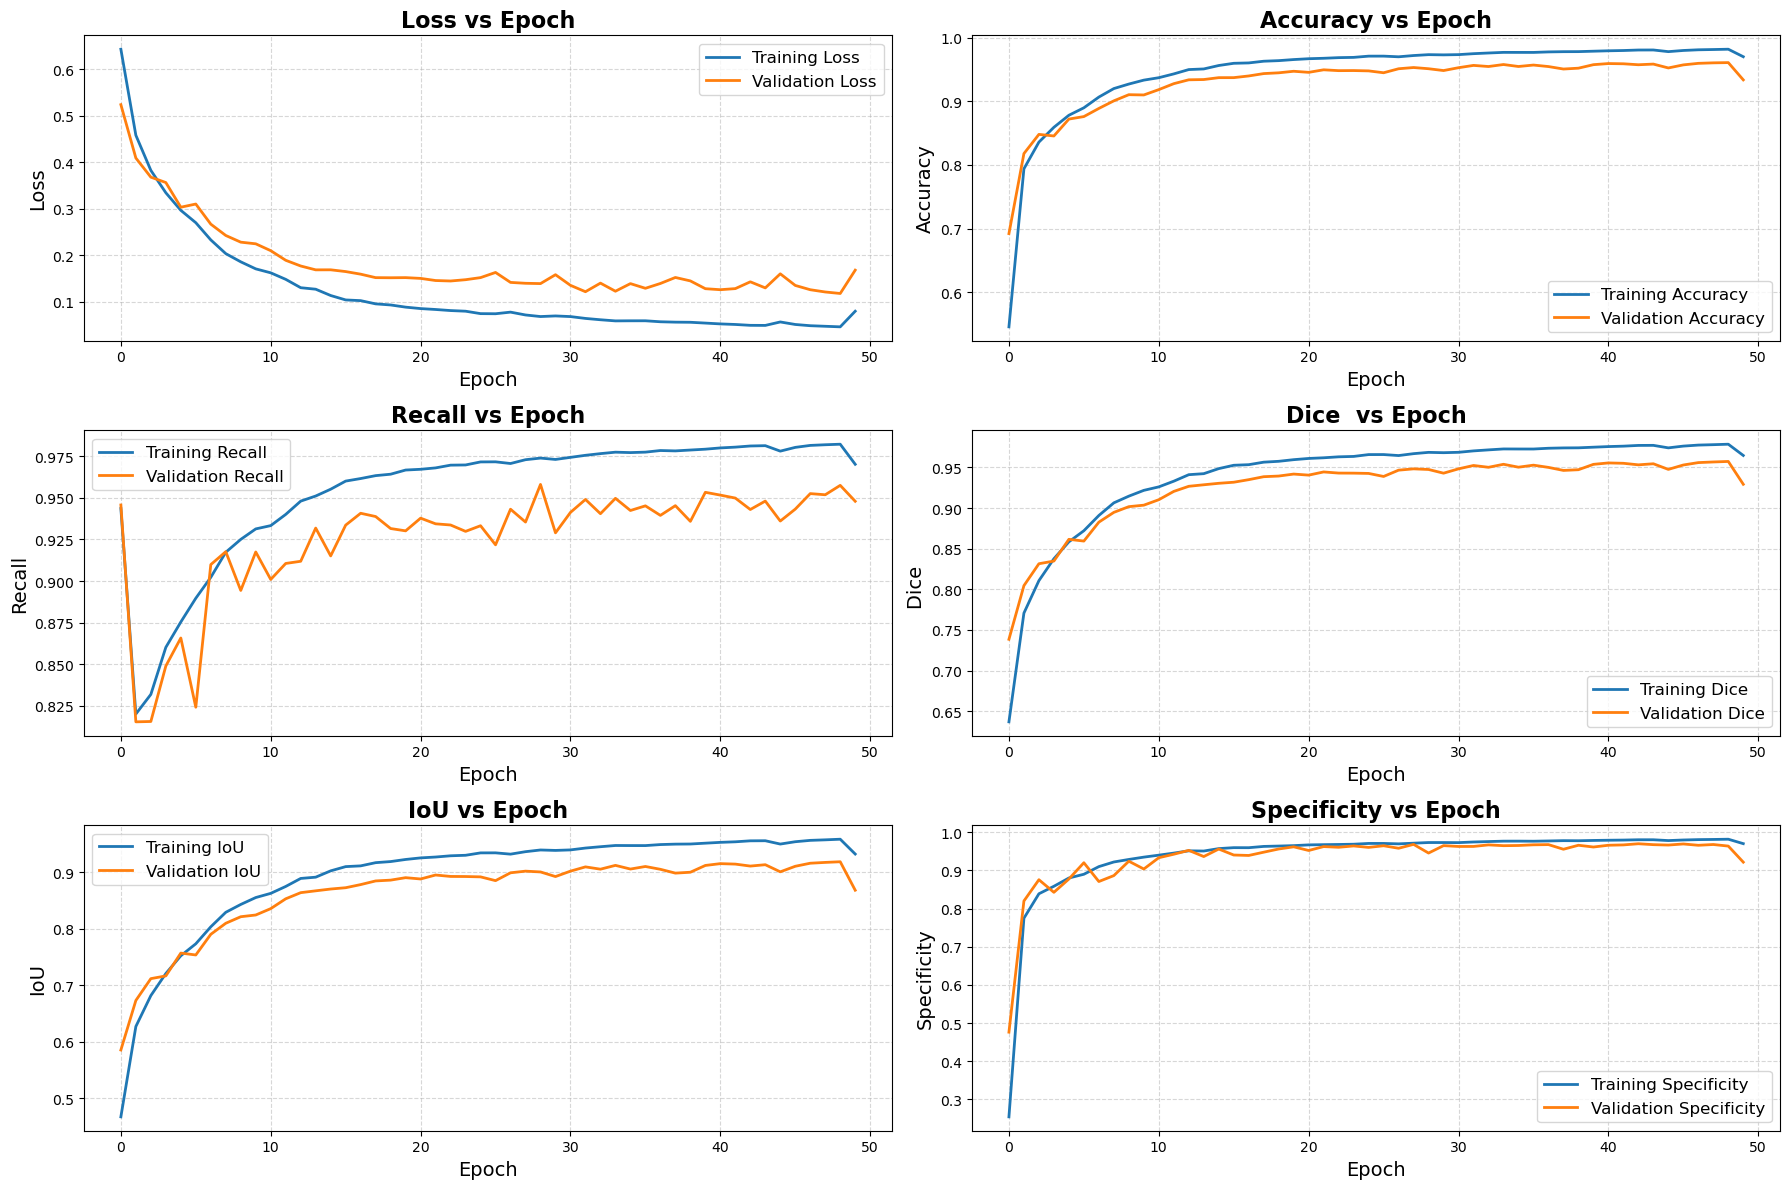

In [5]:
import matplotlib.pyplot as plt

# اندازه‌ی بزرگتر برای افزایش وضوح
plt.figure(figsize=(18, 12))

# زیباتر کردن فونت‌ها
font_title = 16
font_label = 14
font_legend = 12

# رسم نمودار Loss
plt.subplot(3, 2, 1)
plt.plot(train_loss, label='Training Loss', color='#1f77b4', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='#ff7f0e', linewidth=2)
plt.xlabel('Epoch', fontsize=font_label)
plt.ylabel('Loss', fontsize=font_label)
plt.title('Loss vs Epoch', fontsize=font_title, fontweight='bold')
plt.legend(fontsize=font_legend)
plt.grid(True, linestyle='--', alpha=0.5)

# استخراج مقادیر از metrics
train_accuracy, train_recall, train_iou, train_dice, train_SP = zip(*train_metrics)
val_accuracy, val_recall, val_iou, val_dice, val_SP = zip(*val_metrics)

# رسم نمودار Accuracy
plt.subplot(3, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy', color='#1f77b4', linewidth=2)
plt.plot(val_accuracy, label='Validation Accuracy', color='#ff7f0e', linewidth=2)
plt.xlabel('Epoch', fontsize=font_label)
plt.ylabel('Accuracy', fontsize=font_label)
plt.title('Accuracy vs Epoch', fontsize=font_title, fontweight='bold')
plt.legend(fontsize=font_legend)
plt.grid(True, linestyle='--', alpha=0.5)

# رسم نمودار Recall
plt.subplot(3, 2, 3)
plt.plot(train_recall, label='Training Recall', color='#1f77b4', linewidth=2)
plt.plot(val_recall, label='Validation Recall', color='#ff7f0e', linewidth=2)
plt.xlabel('Epoch', fontsize=font_label)
plt.ylabel('Recall', fontsize=font_label)
plt.title('Recall vs Epoch', fontsize=font_title, fontweight='bold')
plt.legend(fontsize=font_legend)
plt.grid(True, linestyle='--', alpha=0.5)

# رسم نمودار Dice Coefficient
plt.subplot(3, 2, 4)
plt.plot(train_dice, label='Training Dice', color='#1f77b4', linewidth=2)
plt.plot(val_dice, label='Validation Dice', color='#ff7f0e', linewidth=2)
plt.xlabel('Epoch', fontsize=font_label)
plt.ylabel('Dice ', fontsize=font_label)
plt.title('Dice  vs Epoch', fontsize=font_title, fontweight='bold')
plt.legend(fontsize=font_legend)
plt.grid(True, linestyle='--', alpha=0.5)

# رسم نمودار IOU
plt.subplot(3, 2, 5)
plt.plot(train_iou, label='Training IoU', color='#1f77b4', linewidth=2)
plt.plot(val_iou, label='Validation IoU', color='#ff7f0e', linewidth=2)
plt.xlabel('Epoch', fontsize=font_label)
plt.ylabel('IoU', fontsize=font_label)
plt.title('IoU vs Epoch', fontsize=font_title, fontweight='bold')
plt.legend(fontsize=font_legend)
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(3, 2, 6)
plt.plot(train_SP, label='Training Specificity', color='#1f77b4', linewidth=2)
plt.plot(val_SP, label='Validation Specificity', color='#ff7f0e', linewidth=2)
plt.xlabel('Epoch', fontsize=font_label)
plt.ylabel('Specificity', fontsize=font_label)
plt.title('Specificity vs Epoch', fontsize=font_title, fontweight='bold')
plt.legend(fontsize=font_legend)
plt.grid(True, linestyle='--', alpha=0.5)

# تنظیم فاصله‌ی نمودارها برای نمایش بهتر
plt.tight_layout()

# نمایش نمودارها
plt.show()


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# ======================== تابع Dice ========================
def calculate_dice(predicted_mask, true_mask):
    intersection = np.logical_and(predicted_mask, true_mask).sum()
    total = predicted_mask.sum() + true_mask.sum()
    dice = (2. * intersection) / total if total != 0 else 1.0
    return dice


def compare_masks_and_images(image, predicted_mask, true_mask):
    fig, axes = plt.subplots(1, 4, figsize=(24, 16))
    
    image = np.clip(image, 0, 1)  
    axes[0].imshow(image.transpose(1, 2, 0))  
    axes[0].set_title('Original Image (Validation)', fontsize=14) 
    axes[0].axis('off')

    predicted_mask = np.squeeze(predicted_mask)  
    im1 = axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask', fontsize=14)
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    true_mask = np.squeeze(true_mask)  
    im2 = axes[2].imshow(true_mask, cmap='gray')
    axes[2].set_title('True Mask', fontsize=14)
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    difference = predicted_mask - true_mask
    difference_image = np.zeros_like(predicted_mask, dtype=np.uint8)
    difference_image[difference == 1] = 255  
    difference_image[difference == -1] = 127  
    im3 = axes[3].imshow(difference_image, cmap='coolwarm')  
    axes[3].set_title('Difference (Prediction vs True)', fontsize=14)
    axes[3].axis('off')
    fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()  

def calculate_error_percentage(predicted_mask, true_mask):
    total_pixels = np.prod(predicted_mask.shape)
    incorrect_pixels = np.sum(predicted_mask != true_mask)
    error_percentage = (incorrect_pixels / total_pixels) * 100
    return error_percentage

def calculate_iou(predicted_mask, true_mask):
    intersection = np.logical_and(predicted_mask, true_mask).sum()
    union = np.logical_or(predicted_mask, true_mask).sum()
    iou = intersection / union if union != 0 else 0
    return iou

def overlay_mask_on_image(image, mask):
    overlay = image.copy()
    overlay = overlay.transpose(1, 2, 0)  
    green_mask = np.zeros_like(overlay)
    green_mask[mask == 1] = [0, 255, 0]  
    combined = cv2.addWeighted(overlay, 0.85, green_mask, 0.15, 0)  
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(combined)
    ax.set_title('Overlay Mask on Image', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()  

# ======================== اجرای مدل و محاسبه متریک‌ها ========================
model.eval()
all_predicted_masks = []
all_true_masks = []

ious = []
dices = []

with torch.no_grad():
    for images, masks in val_loader:  
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))  
        predicted_masks = (outputs > 0.5).cpu().numpy().astype(np.uint8) 
        true_masks = masks.cpu().numpy().astype(np.uint8)

        all_predicted_masks.extend(predicted_masks)
        all_true_masks.extend(true_masks)

        for i in range(len(images)):
            image = images[i].cpu().numpy()  
            predicted_mask = np.squeeze(predicted_masks[i])  
            true_mask = np.squeeze(true_masks[i])  
            compare_masks_and_images(image, predicted_mask, true_mask)

            iou = calculate_iou(predicted_mask, true_mask)
            dice = calculate_dice(predicted_mask, true_mask)

            ious.append(iou)
            dices.append(dice)

            print(f'IoU for Image {i}: {iou:.4f}')
            print(f'Dice for Image {i}: {dice:.4f}')
            
            overlay_mask_on_image(image, predicted_mask)
